In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as spstats
import sklearn
import seaborn as sns
import datetime 

# brewery_id,brewery_name,review_time,review_overall,
# review_aroma,review_appearance,review_profilename,
# beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid

def timestamp_to_datetime(ts):
    """
    Convert a timestamp to a datetime.
    ts: epoch in seconds since 1970-01-01
    """
    return datetime.datetime.fromtimestamp(float(ts))

main_df = pd.read_csv(
    'beer_reviews.csv', 
    parse_dates=['review_time'],
    date_parser=timestamp_to_datetime
)

main_df.head()

,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
0,10325,Vecchio Birraio,2009-02-16 12:57:03,1.5,2.0,2.5,stcules,Hefeweizen,1.5,1.5,Sausa Weizen,5.0,47986
1,10325,Vecchio Birraio,2009-03-01 05:44:57,3.0,2.5,3.0,stcules,English Strong Ale,3.0,3.0,Red Moon,6.2,48213
2,10325,Vecchio Birraio,2009-03-01 06:10:04,3.0,2.5,3.0,stcules,Foreign / Export Stout,3.0,3.0,Black Horse Black Beer,6.5,48215
3,10325,Vecchio Birraio,2009-02-15 11:12:25,3.0,3.0,3.5,stcules,German Pilsener,2.5,3.0,Sausa Pils,5.0,47969
4,1075,Caldera Brewing Company,2010-12-30 10:53:26,4.0,4.5,4.0,johnmichaelsen,American Double / Imperial IPA,4.0,4.5,Cauldron DIPA,7.7,64883


# 1. Prep work and EDA
Data cleaning procedures
- ABV: replace negative with 0
- review scores: clip within [1,5]

For `beer_df` (1 row for each beer): 
- all procedures above
- ABV, style, name, brewery id: use the mode (most frequent value) for this beer's id 

In [2]:
def cleanup(df):
    df.rename(
        {
            'beer_beerid':'bid', 
            'beer_abv':'abv', 
            'beer_style':'style',
            'beer_name': 'name',
            'review_profilename':'reviewer',
        }, 
        axis='columns', 
        inplace=True
    )
    df.dropna(inplace=True) # dropping is quick and dirty, could be smarter, eg replace with avg or -1

    # keep review scores within 1-5 range
    # https://www.beeradvocate.com/community/threads/how-to-review-a-beer.241156/
    review_columns = [
        'review_aroma',
        'review_appearance',
        'review_palate',
        'review_taste',
        'review_overall'
    ]
    df[review_columns] = df[review_columns].clip(1, 5)
    df['abv'].clip(lower=0, inplace=True)
    df['style'] = df['style'].astype('category') # TODO: df['style_cat'] = df['style'].cat.codes
    # df.set_index('bid',inplace=True) # TODO: make this idempotent
    return df 

main_df = cleanup(main_df)
main_df.sample(3,random_state=123)

,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,reviewer,style,review_palate,review_taste,name,abv,bid
1237288,604,Brasserie Dubuisson Frères sprl,2010-03-18 18:24:54,4.0,4.5,4.0,NHGrafx,Belgian Strong Pale Ale,4.5,4.5,Bush Ambrée,12.0,1602
699067,130,Boulder Beer / Wilderness Pub,2008-08-30 10:19:19,4.0,4.5,3.5,DHermit,English India Pale Ale (IPA),4.0,3.5,Cold Hop British-Style Ale,6.8,36468
1551529,345,Victory Brewing Company,2007-05-10 02:21:14,5.0,4.5,4.0,Beertron,German Pilsener,4.0,4.5,Prima Pils,5.3,1010


In [3]:
main_df.describe()

,brewery_id,review_overall,review_aroma,review_appearance,review_palate,review_taste,abv,bid
count,1.518478e+06,1.518478e+06,1.518478e+06,1.518478e+06,1.518478e+06,1.518478e+06,1.518478e+06,1.518478e+06
mean,3.074306e+03,3.823942e+00,3.746218e+00,3.850388e+00,3.753735e+00,3.804082e+00,7.042488e+00,2.140575e+04
std,5.544339e+03,7.172449e-01,6.953440e-01,6.142854e-01,6.793350e-01,7.286079e-01,2.322568e+00,2.178033e+04
min,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e-02,5.000000e+00
25%,1.410000e+02,3.500000e+00,3.500000e+00,3.500000e+00,3.500000e+00,3.500000e+00,5.200000e+00,1.654000e+03
50%,4.170000e+02,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,6.500000e+00,1.283000e+04
75%,2.298000e+03,4.500000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.500000e+00,8.500000e+00,3.923600e+04
max,2.800300e+04,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.770000e+01,7.731600e+04


In [4]:
# Build a beer dataset, ie one row per beer.
def mode(series):
    """ given a series, return its mode 
    https://github.com/pandas-dev/pandas/issues/11562
    """
    return pd.Series.mode(series)[0]

def build_beer_df(df):
    beer_df = ( # one row per beer
        df
        .groupby('bid')
        .agg({
            'brewery_id':mode, # get most frequently-given brewery, in case of DQ issue
            'style':mode,
            'name':mode,
            'abv':mode,
            'review_overall':['count','mean','std'], # TODO: compute pct reviews giving N stars
            'review_aroma':['mean','std'],
            'review_appearance':['mean','std'],
            'review_palate':['mean','std'],
            'review_taste':['mean','std'],
        })
    )
    beer_df.columns = ["_".join(x) for x in beer_df.columns.ravel()] # flatten multi-index
    beer_df.rename(
        {
            'brewery_id_mode': 'brewery_id',
            'review_overall_count': 'n_reviews',
            'abv_mode': 'abv',
            'style_mode':'style',
            'name_mode':'name'
        },
        axis='columns',
        inplace=True
    )
    return beer_df

beer_df = build_beer_df(main_df)
beer_df.head()


,brewery_id,style,name,abv,n_reviews,review_overall_mean,review_overall_std,review_aroma_mean,review_aroma_std,review_appearance_mean,review_appearance_std,review_palate_mean,review_palate_std,review_taste_mean,review_taste_std
bid,,,,,,,,,,,,,,,
5,3,Vienna Lager,Amber,4.5,424,3.549528,0.676278,3.205189,0.599741,3.485849,0.549909,3.318396,0.636770,3.340802,0.644130
6,3,English Brown Ale,Turbodog,5.6,877,3.706956,0.629096,3.515964,0.555459,3.836374,0.456147,3.513113,0.565967,3.645382,0.569099
7,3,Fruit / Vegetable Beer,Purple Haze,4.2,659,3.266313,0.823304,3.179059,0.706968,3.251138,0.619082,3.106980,0.676582,3.101669,0.751582
8,3,American Adjunct Lager,Wheat,4.2,68,3.647059,0.872716,3.080882,0.666973,3.294118,0.618347,3.301471,0.707844,3.235294,0.745487
9,3,American Pale Lager,Golden,4.2,116,3.400862,0.746644,2.853448,0.618614,3.051724,0.583763,3.103448,0.630794,3.043103,0.667796


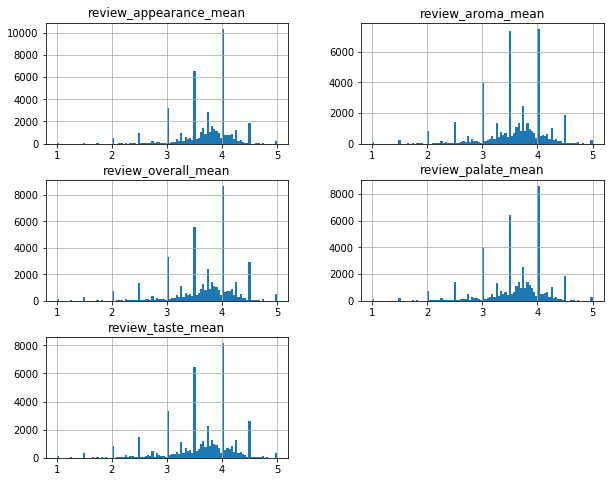

In [5]:
# what are the ratings like?
def histogram_avg_review_scores(df):
    review_mean_columns = [
        'review_aroma_mean',
        'review_appearance_mean',
        'review_palate_mean',
        'review_taste_mean',
        'review_overall_mean'
    ]
    df[review_mean_columns].hist(bins=100,figsize=(10,8))
    # beer_df[review_mean_columns].plot.kde()

histogram_avg_review_scores(beer_df)

# 2. Weirdest beers

Weird is a vague term. Let's look at beers that stand out in some way.
Take-aways of this section:
- `90 Minute IPA` is the most reviewed beer (3289 reviews), when 30% of beers have only 1 review.
- `Genesee NA` has the lowest ABV: .05%. FYI this is the legal threshold for alcohol-free [in the UK](https://en.wikipedia.org/wiki/Low-alcohol_beer).
- `Sink The Bismarck!` has the highest ABV, 41%. Similar ABV as Whisky.
- 100 reviews is a good threshold for "popular" beers: beers with 100+ reviews make up 6% of beers and 74% of reviews. 
For reference, the typical rating for popular beers is 3.7.
- `Crazy Ed's Cave Creek Chili Beer` has the lowest rating of popular beers at 1.49. Why are so many people drinking it? Is it so bad that it's actually good?
- `Citra DIPA` has the highest rating of popular beers at 4.63. This is a lot. >99% of popular beers are below 4.5. 


total beers: 49000
beers with >1k reviews: 199 
beers with 1 review: 15617 
beers with 10+ reviews: 12878 
beer with most reviews: `90 Minute IPA` has 3289 reviews, which is 0.22% of all reviews


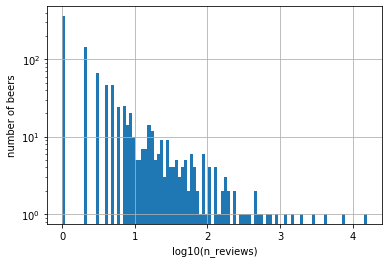

In [6]:
# are there very popular beers that get reviewed a lot? how many are reviewed only once?
def eda_histogram_popularity(beer_df):
    fig, ax = plt.subplots()
    np.log10(beer_df['n_reviews'].value_counts()).hist(bins=100)
    ax.set(xlabel="log10(n_reviews)", ylabel="number of beers", yscale='log')
    print(f"total beers: {len(beer_df)}")
    print(f"beers with >1k reviews: {len(beer_df.query('n_reviews>1000'))} ")
    print(f"beers with 1 review: {len(beer_df.query('n_reviews==1'))} ")
    print(f"beers with 10+ reviews: {len(beer_df.query('n_reviews>=10'))} ")
    name, reviews = beer_df.loc[beer_df['n_reviews'].idxmax(),['name','n_reviews']]
    pct_reviews = reviews / beer_df['n_reviews'].sum()*100
    print(f"beer with most reviews: `{name}` has {reviews} reviews, which is {pct_reviews:.2f}% of all reviews")

eda_histogram_popularity(beer_df)

number of beers with zero abv: 0


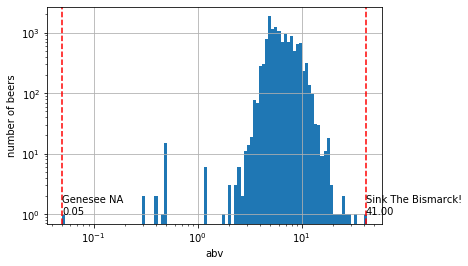

In [7]:
# Looks like lots of beers have only 1 review. 
# The beer might be obscure, or the review unreliable, or user typos in beer name generate new ids.

# Let's look at ABV: keep only beers with 10+ reviews and abv>0.

def build_popular_beer_df(beer_df,n_reviews=100):
    """ given df with one row per beer, keep only beers with at least n_reviews and abv>0 """
    return beer_df.query(f"n_reviews>={n_reviews} & abv>0")
    
def eda_abv(beer_df):
    """ return nothing """
    n_zero_abv_beers = len(beer_df.query('abv==0'))
    print(f"number of beers with zero abv: {n_zero_abv_beers}")

# weird beers: min and max abv
def plot_hist_and_print_min_max(df, value_column, name_column, ylabel, loglog=False, nbins=100):
    """ Plot a histogram of value_column for this df.
    Indicate the name of min and max on plot, using df[name_column].
    return nothing
    """
    min_name, min_val = df.loc[df[value_column].idxmin(),[name_column,value_column]] 
    max_name, max_val = df.loc[df[value_column].idxmax(),[name_column,value_column]]
    
    if loglog:
        bins = np.logspace(np.log10(min_val), np.log10(max_val+1), nbins)
    else:
        bins = np.linspace(min_val, max_val, nbins)
        
    ax = df[value_column].hist(bins=bins)
    scale = 'log' if loglog else 'linear'
    ax.set(xlabel=value_column, ylabel=ylabel, yscale=scale, xscale=scale)
    
    ax.axvline(min_val, color='r', linestyle='--')
    ax.text(min_val,1,f"{min_name}\n{min_val:.2f}")
    
    ax.axvline(max_val, color='r', linestyle='--')
    ax.text(max_val,1,f"{max_name}\n{max_val:.2f}")


eda_abv(beer_df)
bdf = build_popular_beer_df(beer_df, n_reviews=10)
plot_hist_and_print_min_max(bdf, 'abv', 'name', 'number of beers', loglog=True)

3083 beers have 100+ reviews (6.29% of all beers, 73.51% of reviews)


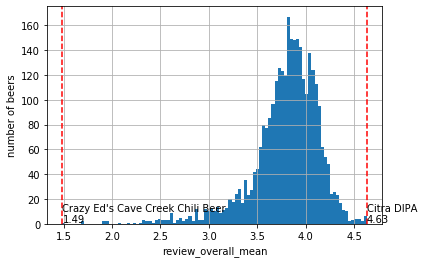

In [8]:
# beer (with at least 100 reviews) with highest review score
def eda_nreviews(bdf):
    """ EDA. bdf is df indexed on beer. return nothing """
    n_beers = len(bdf)
    pct_beers = 100*len(bdf) / len(beer_df)
    pct_reviews = 100 * bdf['n_reviews'].sum() / beer_df['n_reviews'].sum()
    print(f"{n_beers} beers have 100+ reviews ({pct_beers :.2f}% of all beers, {pct_reviews:.2f}% of reviews)")

bdf = build_popular_beer_df(beer_df, n_reviews=100)
eda_nreviews(bdf)
plot_hist_and_print_min_max(bdf, 'review_overall_mean', 'name', 'number of beers')

# 3. What drives the overall review score?

Summary:
- Top factors: `average taste score` predicts overall score the most.
Second is `average palate score`, third `ABV`.
- Quantifying their importance is difficult. 
Reviewers provide very similar scores for overall, taste, palate, etc.
This makes it difficult to get a separate signal for taste and palate.
- On the plus side, the top 3 factors are sufficient to explain >90% of variance in the overall score.
- Methods: we tried 2 random forest methods to quantify feature importance:
1) feature variance/MSE, and 2) relative impact of dropping feature on R2.

In [9]:
def build_review_score_drivers_df(beer_df, min_reviews=10):
    """ takes a df with one row per beer
    add some columns, normalize some, drop others
    return a df with one row per beer
    """
    bdf = beer_df.query(f"n_reviews>={min_reviews}").copy() # keep only beers with enough reviews

    # add some features that may be useful
    bdf['random'] = np.random.random(size = len(bdf)) # add random for baseline importance
    bdf['name_length'] = bdf['name'].str.len() # theory: longer names sound fancier and bias ratings upward

    # compute relative sd, aka CV https://en.wikipedia.org/wiki/Coefficient_of_variation
    review_props = ['aroma','appearance','palate','taste','overall']
    for prop in review_props:
        bdf[f'review_{prop}_rsd'] = bdf[f'review_{prop}_std'] / bdf[f'review_{prop}_mean']

    # normalize means
    for prop in review_props:
        colname = f'review_{prop}_mean'
        bdf[f'review_{prop}_nmean'] = (bdf[colname] - bdf[colname].mean()) / bdf[colname].std()

    # TODO: categorize style, eg boolean for Lager vs Ale

    # keep only usable features
    features_colnames = [
        'abv',
        'n_reviews',
        'name_length',
        'random',
        'review_aroma_nmean',
        'review_aroma_rsd',
        'review_appearance_nmean',
        'review_appearance_rsd',
        'review_palate_nmean',
        'review_palate_rsd',
        'review_taste_nmean',
        'review_taste_rsd',
    ]
    label_colname = 'review_overall_nmean'
    bdf = bdf[features_colnames + [label_colname]]
    return bdf

bdf = build_review_score_drivers_df(beer_df)
print(f'bdf shape: {bdf.shape}')
bdf.sample(5,random_state=456)


bdf shape: (12878, 13)


,abv,n_reviews,name_length,random,review_aroma_nmean,review_aroma_rsd,review_appearance_nmean,review_appearance_rsd,review_palate_nmean,review_palate_rsd,review_taste_nmean,review_taste_rsd,review_overall_nmean
bid,,,,,,,,,,,,,
4528,5.90,48,22,0.577428,-0.039046,0.131931,0.091622,0.140910,0.501162,0.141502,0.395532,0.124440,0.662444
3747,5.20,58,15,0.471369,-0.275918,0.168340,-0.423630,0.186991,-0.385817,0.150538,-0.499104,0.187568,-0.710272
1163,5.20,837,21,0.707501,-0.042000,0.144418,0.697916,0.121223,0.305636,0.168554,0.207705,0.153817,0.437609
22919,4.75,81,12,0.590291,-0.150990,0.121378,0.357770,0.078734,0.148387,0.129385,0.116132,0.121766,0.230550
64091,5.50,15,13,0.389449,0.199090,0.150732,-0.250569,0.142709,0.042743,0.183434,0.328376,0.117357,0.179914


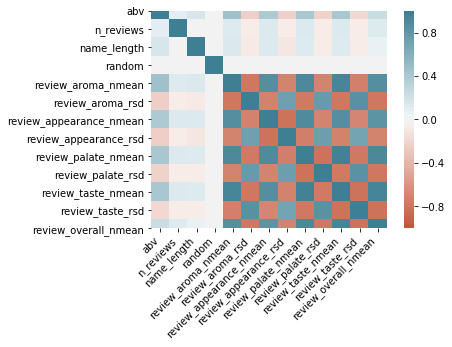

In [10]:
# this is too slow

# from scipy.stats import pearsonr

# def corrfunc(x, y, ax=None, **kws):
#     """Plot the correlation coefficient in the top left hand corner of a plot.
#     https://stackoverflow.com/a/50835066
#     """
#     r, pval = pearsonr(x, y)
#     ax = ax or plt.gca()
#     ax.annotate(f'r = {r:.2f}', xy=(.1, .9), xycoords=ax.transAxes)
    
# review_columns = [f'review_{s}_nmean' for s in review_props]
# g = sns.pairplot(
#     bdf,
#     kind="reg",
#     markers='+',
#     plot_kws={'line_kws':{'color':'red'}}
# )
# g.map_lower(corrfunc) # add pearson r
# plt.show()

# this is faster, and all we really need
# https://towardsdatascience.com/better-heatmaps-and-correlation-matrix-plots-in-python-41445d0f2bec
def plot_correl_matrix(bdf):
    corr = bdf.corr()
    ax = sns.heatmap(
        corr, 
        vmin=-1, vmax=1, center=0,
        cmap=sns.diverging_palette(20, 220, n=200),
        square=True
    )
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right'
    )
    
plot_correl_matrix(bdf)

Some take-aways from the correlation matrix above:
1. The average scores for aroma, appearance, palate, and taste,
are all correlated with each other, and with the overal score. 
There are 2 possible explanations:
The first, is that reviewers don't make the difference between the 5 scores,
so we should probably change the prompts or educate reviewers about them.
Another possibility is that beers are good-all-around or bad-all-around, 
ie a good aroma always comes together with a good palate and taste (which is believable) 
and appearance (less believable).
Either way, we need to tackle this colinearity issue.
One solution would be to reduce the 4 dimensions into 1-2, eg via PCA,
but this would lose some interpretability.
Another solution is to keep only one of those features, but then we lose their contribution, 
which could be big _after_ random forest picked the first feature (eg aroma).
Quick and dirty non-solution: keep all features and remember the colinearity.
2. For all 4 review factors, RSDs are always strongly negatively correlated with the factor means
and with the overall mean. 
This means when beers have a high overall score, reviews are typically in agreement.
When beers have a lower overall score, reviews are more spread out.
3. All 4 RSDs are super negatively correlated with overall score. Let's keep only `review_taste_rsd`.
4. Higher ABV, longer names, and higher popularity (more reviews) correlate with higher overall score. 

In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split


def prep_train_valid_sets(df, label, column_blacklist=[], seed=123):
    """
    Return train and validation sets
    Plot feature importance in barplot
    """
    # ignore columns in blacklist
    features = [col for col in bdf.columns if col != label and col not in column_blacklist]
    
    # split
    x_train, x_valid, y_train, y_valid = train_test_split(
        df[features], 
        df[label], 
        test_size = 0.8, 
        random_state = seed
    )
    return x_train, x_valid, y_train, y_valid


def train_rf(x_train, y_train, n_trees=200, seed=123):
    """ Return a random forest regressor of y ~ x """
    rf = RandomForestRegressor(
        n_estimators = n_trees,
        n_jobs = -1,
        oob_score = True,
        bootstrap = True,
        random_state = seed
    )
    rf.fit(x_train, y_train)
    return rf
    
    
def compute_rf_perf_and_importance(rf, x_train, y_train, x_valid, y_valid):
    """
    Given a random forest model, compute R2 and feature importances.
    Return:
    - model performance: r-square on train, on OOB during training, and on validation.
    - df mapping each feature name to its importance in [0,1]
    """
    # https://towardsdatascience.com/explaining-feature-importance-by-example-of-a-random-forest-d9166011959e
    # https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
    
    # performance scores
    r2_train = rf.score(x_train, y_train)
    r2_oob = rf.oob_score_
    r2_valid = rf.score(x_valid, y_valid)
    
    # feature importance
    importance_df = (
        pd.DataFrame({
            'name': list(x_train.columns),
            'importance': rf.feature_importances_
        })
        .set_index('name')
        .sort_values('importance', ascending=False)
    )
    
    return r2_train, r2_oob, r2_valid, importance_df


def display_perf_importance(r2_train, r2_oob, r2_valid, importance_df):
    """ Given performance of a model,
    and feature importance df,
    plot importance as barplot,
    and simply print importance_df.
    Return nothing
    """
    print(f"r2 train: {r2_train:.2f} \nr2 oob: {r2_oob:.2f} \nr2 valid: {r2_valid:.2f}")
    ax = importance_df.plot(kind='bar')
    ax.set(yscale='log')
    plt.axhline(y=importance_df.loc['random'][0], color='r', linestyle='dotted')
    print(importance_df)


r2 train: 0.99 
r2 oob: 0.92 
r2 valid: 0.93
                         importance
name                               
review_taste_nmean         0.887774
review_palate_nmean        0.027431
abv                        0.025287
review_taste_rsd           0.011587
review_aroma_nmean         0.009121
review_palate_rsd          0.006663
review_appearance_nmean    0.006366
review_appearance_rsd      0.006228
review_aroma_rsd           0.005736
random                     0.004783
n_reviews                  0.004740
name_length                0.004285


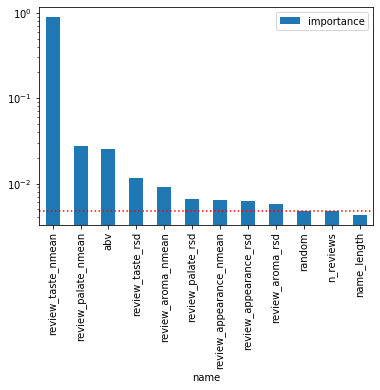

In [12]:
# let's finally get and plot importances
def get_factor_importance(bdf, label, column_blacklist=[]):
    """ Wrap all functions above together.
    given a beer df and continuous label, train a regression forest, 
    print its performance, return nothing.
    """
    x_train, x_valid, y_train, y_valid = prep_train_valid_sets(bdf, label)
    rf = train_rf(x_train, y_train)
    r2_train, r2_oob, r2_valid, importance_df = compute_rf_perf_and_importance(rf, x_train, y_train, x_valid, y_valid)
    display_perf_importance(r2_train, r2_oob, r2_valid, importance_df)
    
get_factor_importance(bdf, 'review_overall_nmean')


r2 train: 0.99 
r2 oob: 0.92 
r2 valid: 0.93
                         importance
name                               
review_taste_nmean         0.003724
abv                        0.002692
review_palate_nmean        0.000800
review_taste_rsd           0.000187
review_aroma_nmean         0.000126
review_appearance_rsd      0.000108
review_aroma_rsd           0.000080
n_reviews                  0.000061
review_appearance_nmean    0.000014
name_length                0.000001
review_palate_rsd         -0.000041
random                    -0.000069


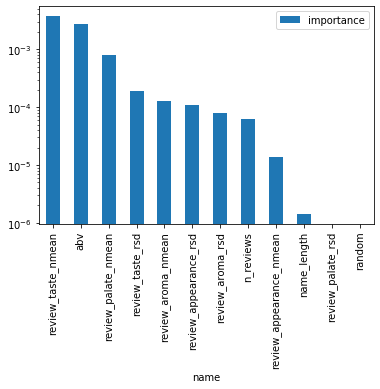

In [13]:
# try another approach to measure importance: impact on R2 of dropping a feature
# https://towardsdatascience.com/explaining-feature-importance-by-example-of-a-random-forest-d9166011959e
from sklearn.base import clone 

def compute_rf_perf_ft_imp_dropping(rf, x_train, y_train, x_valid, y_valid):
    """
    Given a random forest model, compute R2 and feature importances.
    In this case, feature importance means impact on R2 of dropping the feature.
    Return:
    - model performance: r-square on train, on OOB during training, and on validation.
    - df mapping each feature name to its importance in [0,1]
    """
    
    # performance scores
    r2_train = rf.score(x_train, y_train)
    r2_oob = rf.oob_score_
    r2_valid = rf.score(x_valid, y_valid)

    # clone model, removing each feature, one at a time, storing importance
    importances = []
    for col in x_train.columns:
        rf_clone = clone(rf) # also copies seed, n_trees, ... everything in rf.get_params() !
        rf_clone.fit(x_train.drop(col, axis = 1), y_train)
        r2_train_clone = rf_clone.score(x_train.drop(col, axis = 1), y_train)
        importances.append(r2_train - r2_train_clone)
    
    # feature importance
    importance_df = (
        pd.DataFrame({
            'name': list(x_train.columns),
            'importance': importances #rf.feature_importances_
        })
        .set_index('name')
        .sort_values('importance', ascending=False)
    )

    return r2_train, r2_oob, r2_valid, importance_df


# let's finally get and plot importances
def get_factor_importance_dropping(bdf, label, column_blacklist=[]):
    """ Wrap all functions above together.
    given a beer df and continuous label, train a regression forest, 
    print its performance, return nothing.
    """
    x_train, x_valid, y_train, y_valid = prep_train_valid_sets(bdf, label)
    rf = train_rf(x_train, y_train)
    r2_train, r2_oob, r2_valid, importance_df = compute_rf_perf_ft_imp_dropping(rf, x_train, y_train, x_valid, y_valid)
    display_perf_importance(r2_train, r2_oob, r2_valid, importance_df)
    
    
get_factor_importance_dropping(bdf, 'review_overall_nmean')


Take-aways:
- Average taste and palate scores remain important, as well as ABV
- Colinearity is so big that the impact on R2 of removing a feature (ie the plot's y axis) is super small.

# 3. Reviewers most likely paid by beer companies

This section explores 2 definitions for "being paid":
1. Reviewing many beers from a given brewery: user `feloniousmonk` for brewery `Minneapolis Town Hall Brewery`.
2. Giving a score abnormally high to many beers from this brewery: `MrHurmateeowish` for brewery `Anheuser-Busch`. 
Note: with this second method, brewery `Anheuser-Busch` is represented in 4 of the top 10 most suspicious 
(reviewer, brewery) pairs. This brewery might be paying these 4 users.

In [14]:
# let's make a (reviewer, brewery) df
reviewer_brewery_df = (
    main_df
    # TODO: check that brewery_name always maps to the same brewery_id
    .groupby(['reviewer','brewery_name'])
    .agg(
        {
            'review_overall':['mean','median','count'], # TODO: can the same user review the same beer twice?
        }
    )
)
# flatten multi-index
reviewer_brewery_df.columns = [
    "_".join(x) for x in reviewer_brewery_df.columns.ravel()
] 
# rename
reviewer_brewery_df.rename(
    {
        'review_overall_mean': 'reviewer_avg_score',
        'review_overall_median': 'reviewer_med_score',
        'review_overall_count': 'reviewer_n_reviews',
    },
    axis='columns',
    inplace=True
)
reviewer_brewery_df.sample(5,random_state=123)

,,reviewer_avg_score,reviewer_med_score,reviewer_n_reviews
reviewer,brewery_name,,,
Gagnonsux,North Coast Brewing Co.,4.50,4.50,2
pmcadamis,Full Sail Brewery & Tasting Room & Pub,4.50,4.50,1
DiabolikDUB,Unibroue,4.50,4.50,1
todd1,Nøgne Ø - Det Kompromissløse Bryggeri A/S,4.00,4.00,1
Derek,Brauerei Hofstetten Krammer GmbH & Co. KG,3.75,3.75,2


In [15]:
# compute avg and median review score for this brewery
brewery_df = (
    main_df
    .groupby('brewery_name')
    .agg(
        {
            'review_overall':['mean','median','count'], # TODO: nunique on beer_id instead of count
            'bid':['nunique']
        }
    ) 
)
# flatten multi-index
brewery_df.columns = [
    "_".join(x) for x in brewery_df.columns.ravel()
] 
# rename
brewery_df.rename(
    {
        'review_overall_mean': 'brewery_avg_score',
        'review_overall_median': 'brewery_med_score',
        'review_overall_count': 'brewery_n_reviews',
        'bid_nunique': 'brewery_n_beers',
    },
    axis='columns',
    inplace=True
)
brewery_df.sample(5,random_state=123)



,brewery_avg_score,brewery_med_score,brewery_n_reviews,brewery_n_beers
brewery_name,,,,
Straight To Ale,4.077778,4.0,45,12
Karlsberg Brauerei,3.216981,3.5,53,15
Honest Town Brewery & The Dark Horse Tavern,3.571429,3.5,7,4
Tuscan Brewing,3.388889,3.5,9,2
Traditionsbrauerei Brauberger zu Lübeck,4.500000,4.5,3,1


In [16]:
enriched_rev_brwry_df = (
    reviewer_brewery_df
    .merge(
        brewery_df, 
        how='inner',
        left_index=True, 
        right_index=True
    )
    .reset_index()
    .rename({'brewery_name':'brewery'}, axis='columns')
)

enriched_rev_brwry_df.sample(5,random_state=123)

,reviewer,brewery,reviewer_avg_score,reviewer_med_score,reviewer_n_reviews,brewery_avg_score,brewery_med_score,brewery_n_reviews,brewery_n_beers
102543,Gagnonsux,North Coast Brewing Co.,4.50,4.50,2,3.980007,4.0,11154,25
546740,pmcadamis,Full Sail Brewery & Tasting Room & Pub,4.50,4.50,1,3.819762,4.0,5293,62
77568,DiabolikDUB,Unibroue,4.50,4.50,1,4.025548,4.0,13915,43
618358,todd1,Nøgne Ø - Det Kompromissløse Bryggeri A/S,4.00,4.00,1,3.894217,4.0,2784,44
75971,Derek,Brauerei Hofstetten Krammer GmbH & Co. KG,3.75,3.75,2,3.828804,4.0,184,10


percentiles of [number of reviews left by a reviewer on a given brewery]:
{'50%': 1.0, '90%': 5.0, '95%': 7.0, '99%': 16.0}


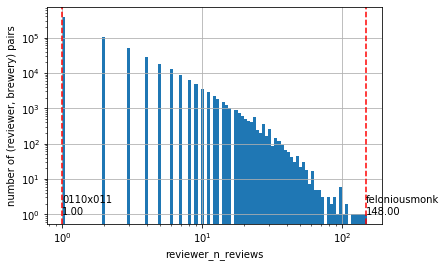

In [17]:
# EDA: are there reviewers who review the same brewery a lot?
# reuse our good old log-log histogram plotter
plot_hist_and_print_min_max(
    enriched_rev_brwry_df, 
    'reviewer_n_reviews', 
    'reviewer', 
    'number of (reviewer, brewery) pairs',
    loglog=True
)

def display_percentiles_n_reviews_per_pair(df, percentiles):
    """ given non-indexed df with one row per (reviewer, brewery) pair,
    print percentile stats for number of reviews for that pair.
    """
    percentiles = {
        f'{p}%': np.percentile(df['reviewer_n_reviews'], p)
        for p in percentiles
    }
    # TODO: plot cdf instead of printing a dict
    print("percentiles of [number of reviews left by a reviewer on a given brewery]:")
    print(percentiles)

display_percentiles_n_reviews_per_pair(enriched_rev_brwry_df, [50,90,95,99])

In [18]:
# one way to define paid reviewers: they review a lot of beers for that brewery
# note: this does not mean they are dishonest or corrupt
# they could also be die-hard fans, who of course don't need to be paid
enriched_rev_brwry_df.sort_values(by='reviewer_n_reviews', ascending=False).head(5)

,reviewer,brewery,reviewer_avg_score,reviewer_med_score,reviewer_n_reviews,brewery_avg_score,brewery_med_score,brewery_n_reviews,brewery_n_beers
401338,feloniousmonk,Minneapolis Town Hall Brewery,4.320946,4.5,148,4.259436,4.5,2623,243
36865,Bighuge,Minneapolis Town Hall Brewery,4.518519,4.5,135,4.259436,4.5,2623,243
286156,akorsak,Tröegs Brewing Company,3.992481,4.0,133,4.056402,4.0,11613,86
115949,Halcyondays,The Bruery,3.968000,4.0,125,3.946196,4.0,7137,143
641180,womencantsail,The Bruery,3.756410,4.0,117,3.946196,4.0,7137,143


In [19]:
# Another way to define paid reviewers: 
# They give a score abnormally high to many beers from this brewery,
# They could be robots, or die-hard fans with unusual tastes.
# Parameters to pick:
# i) how many is "many" beers? Arbitrarily going for 16 because 99th percentile.
# ii) what is an "abnormally high" score? Arbitrarily going for .5 point above the average.

#  add delta of this user's avg score for this brewery vs all users' average score for this brewery
enriched_rev_brwry_df['delta_avg_score'] = (
    enriched_rev_brwry_df['reviewer_avg_score'] 
    - enriched_rev_brwry_df['brewery_avg_score']
)

(
    enriched_rev_brwry_df
    .query('(reviewer_n_reviews>=16) & (delta_avg_score>.5)')
    [['reviewer','brewery','reviewer_avg_score','brewery_avg_score','delta_avg_score']]
    # TODO: could also add ['reviewer_n_reviews','brewery_n_beers']
    .sort_values(by='delta_avg_score', ascending=False)
    .head(10)
)
# AH! 4 out of the top 10 pairs come from the same brewery! 
# Brewery "Anheuser-Busch" might have paid reviewers.


# TODO: look at the delta for reviewers whose 10+ reviews are all for the same brewery

,reviewer,brewery,reviewer_avg_score,brewery_avg_score,delta_avg_score
176699,MrHurmateeowish,Anheuser-Busch,3.820000,2.802286,1.017714
492226,marlinsfan4,Anheuser-Busch,3.785714,2.802286,0.983428
222654,SargeC,"Kirin Brewery Company, Limited",3.921053,2.956195,0.964857
505317,mikesgroove,White Birch Brewing,4.583333,3.639617,0.943716
145736,KI9A,Anheuser-Busch,3.729167,2.802286,0.926880
216045,RonaldTheriot,Anheuser-Busch,3.693548,2.802286,0.891262
537188,oteyj,De Struise Brouwers,5.000000,4.128686,0.871314
500136,mempath,Matt Brewing Company,4.357143,3.522816,0.834327
500091,mempath,Boston Beer Company (Samuel Adams),4.500000,3.692045,0.807955
93040,FARGO619,Stone Brewing Co.,4.789474,4.040428,0.749045


# 4. Which beer would you recommend given this dataset?

I'm going to re-use results from the previous questions, because I am running out of time. 

Recommendations depend heavily on the audience. To make it easier for myself,
I'm picking the audience to be: _someone who's never drunk beers before_.

I would recommend them to try the following beers _in this order_:
1. `Crazy Ed's Cave Creek Chili Beer`: low score, yet >100 reviews. Why are so many people drinking it? Is it so bad that it's actually good? Maybe it's a good beer to start with, to anchor expectations.
2. `Citra DIPA`: highest-rated beer with 100+ reviews. Best contrast.
3. `90 Minute IPA`: most reviewed (and therefore probably easy to find), and good score.
4. `Genesee NA`: alcohol-free mouthwash to sober up, if you have to drive back from the pub.

# 5. Select 4 beers that allow you to “taste the breadth of all beers”

Method:
- Run PCA on beers with 100+ reviews (enough reviews to get signal).
- Then scatter plot these beers along the top 2 PCA dimensions.
- In each of the 4 quadrants, pick the beer with highest L2 norm.
- Bonus: variance explained by the top 2 axes is a measure of "breadth".

Answer:
- `Samuel Adams Triple Bock`
- `Samuel Adams Utopias`
- `Budweiser Select 55`
- `Deviation - Bottleworks 9th Anniversary`
- These beers are 4 extremes spanning (at least) 79% of the variance among all beers with 100+ reviews.

In [20]:

def fetch_beer_data(df):
    """ 
    return df of continuous features and with one column as label,
    and name of label column
    """
    beer_df = build_beer_df(df)
    beer_df = beer_df.query("n_reviews>=100").reset_index(drop=True)
    label_colname = 'name' # label as in text to plot, no to predict
    # keep only continuous features and label
    columns = [
        'abv',
        'n_reviews',
        'review_overall_mean',
        'review_overall_std',
        'review_aroma_mean',
        'review_aroma_std',
        'review_appearance_mean',
        'review_appearance_std',
        'review_palate_mean',
        'review_palate_std',
        'review_taste_mean',
        'review_taste_std',
        label_colname
    ]
    
    return beer_df[columns], label_colname

beers_df, label_colname = fetch_beer_data(main_df)
beers_df.head()

,abv,n_reviews,review_overall_mean,review_overall_std,review_aroma_mean,review_aroma_std,review_appearance_mean,review_appearance_std,review_palate_mean,review_palate_std,review_taste_mean,review_taste_std,name
0,4.5,424,3.549528,0.676278,3.205189,0.599741,3.485849,0.549909,3.318396,0.636770,3.340802,0.644130,Amber
1,5.6,877,3.706956,0.629096,3.515964,0.555459,3.836374,0.456147,3.513113,0.565967,3.645382,0.569099,Turbodog
2,4.2,659,3.266313,0.823304,3.179059,0.706968,3.251138,0.619082,3.106980,0.676582,3.101669,0.751582,Purple Haze
3,4.2,116,3.400862,0.746644,2.853448,0.618614,3.051724,0.583763,3.103448,0.630794,3.043103,0.667796,Golden
4,7.0,716,3.826117,0.566058,3.747207,0.523229,3.936453,0.485969,3.742318,0.555592,3.767458,0.561631,Allagash Dubbel Ale


In [21]:
# https://github.com/mGalarnyk/Python_Tutorials/blob/master/Sklearn/PCA/PCA_Data_Visualization_Iris_Dataset_Blog.ipynb
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def run_pca(df, label_colname):
    """ Run PCA on a df of continuous features, ignoring colum label_colname
    return a df with columns=[dim1,dim2,dist, label_colname] of the top 2 PCA components + label
    """
    # normalize
    colnames = [col for col in df.columns if col != label_colname]
    scaled_df = StandardScaler().fit_transform(df[colnames]) 
    scaled_df = pd.DataFrame(data=scaled_df, columns=colnames)
    # actual PCA
    pca = PCA(n_components=2)
    components = pca.fit_transform(scaled_df) # 2xN df
    explained_variance = pca.explained_variance_ratio_

    # wrangling
    pca_2d_df = pd.concat(
        [
            pd.DataFrame(data=components, columns=['dim1', 'dim2']), 
            df[label_colname]
        ],
        axis = 1
    )

    pca_2d_df['dist'] = pca_2d_df['dim1']**2 + pca_2d_df['dim2']**2 # TODO: move this in the plotting func instead
    return pca_2d_df, explained_variance

pca_2d_df, explained_variance = run_pca(beers_df, label_colname)
print(f'explained variance: {explained_variance}')
pca_2d_df.head()



explained variance: [0.66718972 0.12332557]


,dim1,dim2,name,dist
0,3.010484,-0.454106,Amber,9.269225
1,0.656231,-0.142338,Turbodog,0.450899
2,5.369391,0.575197,Purple Haze,29.161216
3,4.733301,-1.139280,Golden,23.702102
4,-0.310387,0.217300,Allagash Dubbel Ale,0.143559


dict_keys(['Samuel Adams Triple Bock', 'Budweiser Select 55', 'Samuel Adams Utopias', 'Deviation - Bottleworks 9th Anniversary'])


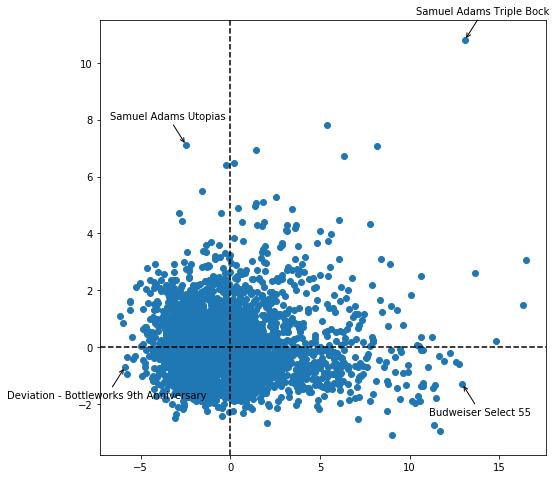

In [22]:

def plot_pca_2d_point_extremes(pca_df, dim1_colname, dim2_colname, dist_colname, label_colname):
    """ Scatter plot in 2d space, 
    point arrows to the 4 corner-most points.
    """
    # https://stackoverflow.com/a/12983510
    fig, ax = plt.subplots(figsize=(8,8))
    ax.scatter(pca_df[[dim1_colname]], pca_df[[dim2_colname]])
    ax.axvline(0, color='k', linestyle='--')
    ax.axhline(0, color='k', linestyle='--')

    # point at most extreme data points in each quadrant
    quadrant_signs = [
        ['>','>'], # top right
        ['>','<'], # bottom right
        ['<','>'], # top left
        ['<','<'], # bottom left
    ]

    extremes = {} # store the farthest (L2 norm) point from origin in each quadrant
    for sign1, sign2 in quadrant_signs:
        query = f'(dim1 {sign1} 0) & (dim2 {sign2} 0)'
        df = pca_df.query(query) # filter data to this quadrant
        name, x, y = df.loc[df[dist_colname].idxmax(),[label_colname, dim1_colname, dim2_colname]]
        extremes[name] = x,y
        ax.annotate(
            name, xy=(x,y), xytext=(x-1 if x<0 else x+1, y-1 if y<0 else y+1),
            arrowprops=dict(arrowstyle='->'), ha='center', va='center'
        )
    
    return extremes
        
extreme_beers = plot_pca_2d_point_extremes(pca_2d_df,'dim1','dim2','dist','name')
print(extreme_beers.keys())